In [20]:
# Remove input cells at runtime (nbsphinx)
import IPython.core.display as d
d.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# IRFs and sensitivity

**WARNING**

This is still a work-in-progress, it will evolve with the pipeline comparisons and converge with ctaplot+cta-benchmarks.

**Author(s):**
    
- Dr. Michele Peresano (CEA-Saclay/IRFU/DAp/LEPCHE), 2020
based on previous work by J. Lefacheur.

**Description:**

This notebook contains DL3 and benchmarks for the _protopipe_ pipeline. 

Note that:
    - a more general set of benchmarks is being defined in cta-benchmarks/ctaplot,
    - follow [this](https://www.overleaf.com/16933164ghbhvjtchknf) document by adding new benchmarks or proposing new ones.

**Requirements:**

To run this notebook you will need a set of DL2 files produced on the grid with protopipe.
The MC production to be used and the appropriate set of files to use for this notebook can be found [here](https://forge.in2p3.fr/projects/step-by-step-reference-mars-analysis/wiki#The-MC-sample ).

The data format required to run the notebook is the current one used by _protopipe_ .
Later on it will be the same as in _ctapipe_ + _pyirf_.

**Development and testing:**  

For the moment this notebook is optimized to work only on files produced from LSTCam + NectarCam telescope configurations.  
As with any other part of _protopipe_ and being part of the official repository, this notebook can be further developed by any interested contributor.  
The execution of this notebook is not currently automatic, it must be done locally by the user - preferably _before_ pushing a pull-request.  
**IMPORTANT:** Please, if you wish to contribute to this notebook, before pushing anything to your branch (better even before opening the PR) clear all the output and remove any local directory paths that you used for testing (leave empty strings).

**TODO:**  
* update everything...

## Table of contents

* [Instrument Response Functions](#Instrument-Response-Functions)
* [Sensitivity](#Sensitivity)

## Imports
[back to top](#Table-of-contents)

In [21]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.table import Table, Column

from gammapy.utils.energy import EnergyBounds
from gammapy.irf import EffectiveAreaTable, EnergyDispersion2D 

from gammapy.spectrum import CrabSpectrum
from gammapy.spectrum.models import PowerLaw

## Functions
[back to top](#Table-of-contents)

In [22]:
def get_performance(filename):
    """Load IRF, use Gammapy capabilities to handle the miragtion matrix"""
    with fits.open(filename, memmap=False) as hdulist:
        aeff = EffectiveAreaTable.from_hdulist(hdulist=hdulist).to_table()
        bkg = Table.read(hdulist["BACKGROUND"])
        psf = Table.read(hdulist["POINT SPREAD FUNCTION"])
        sens = Table.read(hdulist["SENSITIVITY"])
        edisp = EnergyDispersion2D.read(filename, hdu="ENERGY DISPERSION")
        rmf = edisp.to_energy_dispersion(offset=0.5 * u.deg)  # Projection of migration matrix, dummy angle...
        
        try:  # Collection area without score/angular cut
            aeff_no_cuts = Table.read(hdulist["SPECRESP (NO CUTS)"])
            aeff_angular_cut = Table.read(hdulist["SPECRESP (WITH ANGULAR CUT)"])
            aeff_score_cut = Table.read(hdulist["SPECRESP (WITH SCORE CUT)"])

            aeff_no_cuts.columns['SPECRESP (NO CUTS)'].name = 'SPECRESP'
            aeff_angular_cut["SPECRESP (WITH ANGULAR CUT)"].name = 'SPECRESP'
            aeff_score_cut["SPECRESP (WITH SCORE CUT)"].name = 'SPECRESP'
        except:
            pass
    
    # Collection area without score/angular cut, that will be used to contain the IRF
    perf = dict(aeff= aeff, bkg= bkg, psf= psf, rmf=rmf, sens=sens, edisp=edisp)

    try:
        perf['aeff_no_cuts'] = aeff_no_cuts
        perf['aeff_angular_cut'] = aeff_angular_cut
        perf['aeff_score_cut'] = aeff_score_cut
    except:
        pass
    
    return perf

def plot_irf(axes, perf, energy_range, label=None, **kwargs):
    """Plot IRFs, take a list of axes (len=4)"""
    plot_table(axes[0], perf['bkg'], 'BGD', label, energy_range, **kwargs)
    plot_table(axes[1], perf['aeff'], 'SPECRESP', label, energy_range, **kwargs)
    plot_table(axes[2], perf['psf'], 'PSF68', label, energy_range, **kwargs)
    plot_energy_response(axes[3], perf['rmf'], label, energy_range, **kwargs)
    
    axes[0].set_xlabel('Reco energy [TeV]')
    axes[0].set_ylabel('Background rate [Hz]')
    axes[0].set_yscale('log')

    axes[1].set_xlabel('True energy [TeV]')
    axes[1].set_ylabel('Effective area [m2]')
    axes[1].set_yscale('log')
    
    axes[2].set_xlabel('Reco energy [TeV]')
    axes[2].set_ylabel('Point spread function (68%) [deg]')
    axes[2].set_ylim([0., 0.5]) # dft 0.5

    axes[3].set_xlabel('True energy [TeV]')
    axes[3].set_ylabel('Energy dispersion [%]')
    axes[3].set_ylim([-0.05, 0.85])
    
    plt.tight_layout()

def plot_sensitivity_comparison(list_perf, list_label, list_color, list_erange, perf_ref, config, title, figsize=(10, 10)):
    """Superpose a list of sensitivity and make a residual plot"""
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(5, 1, hspace=0.05)
    #ax_sens = plt.subplot(gs[:-1, :])
    ax_sens = plt.subplot(gs[:-2, :])
    #ax_res = plt.subplot(gs[4, :])
    ax_res = plt.subplot(gs[-2:, :])
    
    sens_list = [perf[config]['sens'] for perf in list_perf]
    
    for idx, sensi in enumerate(sens_list):
        plot_sensitivity(
            ax_sens,
            sensi,
            list_label[idx],
            list_erange[idx],
            **{'color': list_color[idx], 'lw': 2}
        )        
    
    emin = perf_ref[config]['sens']['ENERG_LO'][0]
    emax = perf_ref[config]['sens']['ENERG_HI'][-1]
    sens_list = []
    for perf in list_perf:
        sens_table = perf[config]['sens']
        new_t = sens_table[(sens_table['ENERG_LO'] >= 0.99 * emin) & (sens_table['ENERG_HI'] <= 1.01 * emax)]
        sens_list.append(new_t)
    
    for idx, sensi in enumerate(sens_list):
        
        plot_sensitivity_residuals(
            ax_res,
            sensi,
            perf_ref[config]['sens'],
            **{'color': list_color[idx], 'lw': 2}
        )
    
    for frac in [0.001, 0.01, 0.1, 1, 10, 100]:
        plot_crab(ax_sens, frac)
    
    sens_min =[sensi['SENSITIVITY'].min() for sensi in sens_list]
    sens_min = min(sens_min)
    
    sens_max =[sensi['SENSITIVITY'].max() for sensi in sens_list]
    sens_max = max(sens_max)
    
    ax_sens.set_xlim([0.02, 200])
    ax_sens.set_ylim([sens_min * 0.5, sens_max * 5])
    ax_sens.legend(loc='upper right', fontsize='large')
    ax_sens.set_xlabel('')
    ax_sens.set_xticklabels([])
    ax_sens.grid()
    ax_sens.loglog()
    ax_sens.set_ylabel('Sensitivity [erg / (cm2 s)]')

    ax_res.plot([-1e9, 1e9], [0., 0.], **{'color': 'darkgreen', 'lw': 2})
    ax_res.grid()
    ax_res.set_xscale('log')
    ax_res.set_ylabel('Betterness')
    ax_res.set_xlabel('Reco energy [TeV]')
    ax_res.set_xlim([0.02, 12.5])
    ax_res.set_ylim([-1, 1])

    ## Text for sensitivity
    text = "Obs. time: {}\n".format(config)
    text += "$\\alpha$=0.2 and $\\sigma$=5\n"
    text += "Syst$_{BKG}$=5% and $\\gamma_{min}$=10"
    ax_sens.text(
            0.1, 0.8 , text,
            horizontalalignment='left',
            verticalalignment='bottom',
            multialignment='left',
            bbox=dict(facecolor='white', alpha=1),
            fontsize='large',
            transform=ax_sens.transAxes
    )
    
    ax_sens.set_title(title, fontweight='bold')
    gs.tight_layout(fig)
    return ax_sens, ax_res
    
def plot_table(ax, t, colname, label, energy_range, **kwargs):
    """Simple function to plot an astropy table"""
    centers = np.sqrt(t['ENERG_LO'] * t['ENERG_HI'])
    bin_width = t['ENERG_HI'] - t['ENERG_LO']
    err_plus = t['ENERG_HI'] - centers
    err_minus = centers - t['ENERG_LO']
    values = t[colname]
    
    # Selection bins in the energy range
    idx = np.where( (centers >= energy_range[0]) & (centers <= energy_range[-1]) )
    ax.errorbar(centers[idx], values[idx], xerr=(err_minus[idx],err_plus[idx]), label=label, **kwargs)
    
    return ax

def plot_energy_response(ax, rmf, label, energy_range, **kwargs):
    """Simple function to plot the energy resolution (Gammapy)"""
    energy = rmf.e_true.nodes
    bias = rmf.get_bias(energy)
    resol = rmf.get_resolution(energy)
    
    idx = np.where( (energy.value >= energy_range[0]) & (energy.value <= energy_range[-1]) )
    
    ax.errorbar(energy.value[idx], bias[idx], **kwargs, ls='--')
    ax.errorbar(energy.value[idx], resol[idx], label=label, **kwargs, ls='-')
    return ax

def plot_sensitivity(ax, t, label, energy_range, **kwargs):
    plot_table(ax, t, 'SENSITIVITY', label, energy_range, **kwargs)
    return ax

def plot_sensitivity_residuals(ax, table_sens, table_ref,**kwargs):
    emin = table_ref['ENERG_LO'][0]
    emax = table_ref['ENERG_HI'][-1]
    t = table_sens[(table_sens['ENERG_LO'] >= 0.99 * emin) & (table_sens['ENERG_HI'] <= 1.01 * emax)]
    
    t_ratio = Table()
    t_ratio['ENERG_LO'] = t['ENERG_LO'].data
    t_ratio['ENERG_HI'] = t['ENERG_HI'].data
    t_ratio['RATIO'] = (1. - (t['SENSITIVITY'] / table_ref['SENSITIVITY']))
    
    plot_table(ax=ax, t=t_ratio, colname='RATIO', label=None, energy_range=[0.01, 300.], **kwargs)
    return ax

def plot_crab(ax, fraction):
    """Plot Crab spectra"""
    crab_model = CrabSpectrum('hegra').model
    reference = 1 * u.TeV
    amplitude = crab_model(energy=reference) * fraction
    index = CrabSpectrum('hegra').model.parameters['index'].value
    energy = np.logspace(-3, 3, 100) * u.TeV
    flux = PowerLaw(amplitude=amplitude, reference=reference, index=index)(energy)
    e2flux = (flux * energy **2) * u.TeV.to('erg')
    ax.plot(energy.value, e2flux.value, ls='--', lw=2, color='grey', alpha=0.5)

## Load
[back to top](#Table-of-contents)

In [23]:
# First we check if a _plots_ folder exists already.  
# If not, we create it.
Path("./plots_DL3").mkdir(parents=True, exist_ok=True)

In [24]:
obs_time = '50h'
site = "North"
array = 'full_array'
zenith = '20'
azimuth = '180'

### protopipe performance
[back to top](#Table-of-contents)

In [25]:
parentDir = "/Users/michele/Applications/ctasoft/dirac"
analysisName = "development_version"

# Files
opti = 'opti'  # r68, fixed, opti
filenames = {'100s': 'irf_tail_ThSq_opti_Time100.00s/irf.fits.gz',
             '30m': 'irf_tail_ThSq_opti_Time30.00min/irf.fits.gz',
             '5h': 'irf_tail_ThSq_opti_Time5.00h/irf.fits.gz',
             '50h': 'irf_tail_ThSq_opti_Time50.00h/irf.fits.gz'}
    
# Full array performance
indir = f"{parentDir}/shared_folder/analyses/{analysisName}/data/DL3"
perf = dict()
for key in filenames.keys():
    perf[key] = get_performance(os.path.join(indir, filenames[key]))

### ASWG's performance
[back to top](#Table-of-contents)

In [26]:
indir = './reference_data/aswg/point-like/LaPalma_20_South/'
indir = os.path.expandvars(indir)
    
filenames = {'100s': 'CTA-Performance-North-20deg-S-onaxis-100s_20170627.fits.gz',
             '30m': 'CTA-Performance-North-20deg-S-onaxis-30m_20170627.fits.gz',
             '5h': 'CTA-Performance-North-20deg-S-onaxis-05h_20170627.fits.gz', 
             '50h': 'CTA-Performance-North-20deg-S-onaxis-50h_20170627.fits.gz'}
perf_mars_fullarray = dict()
for key in filenames.keys():
    perf_mars_fullarray[key] = get_performance(os.path.join(indir, filenames[key]))

### Requirements
[back to top](#Table-of-contents)

In [27]:
indir = './reference_data/requirements/'

# Full array
infiles = dict(sens=f'/{site}-{obs_time}.dat') # 30 min
requirements = dict()
for key in infiles.keys():
    requirements[key] = Table.read(indir + infiles[key], format='ascii')
requirements['sens'].add_column(Column(data=(10**requirements['sens']['col1']), name='ENERGY'))
requirements['sens'].add_column(Column(data=requirements['sens']['col2'], name='SENSITIVITY'))

## Instrument Response Functions
[back to top](#Table-of-contents)

/Users/michele/Applications/miniconda3/envs/protopipe-0.3.0/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


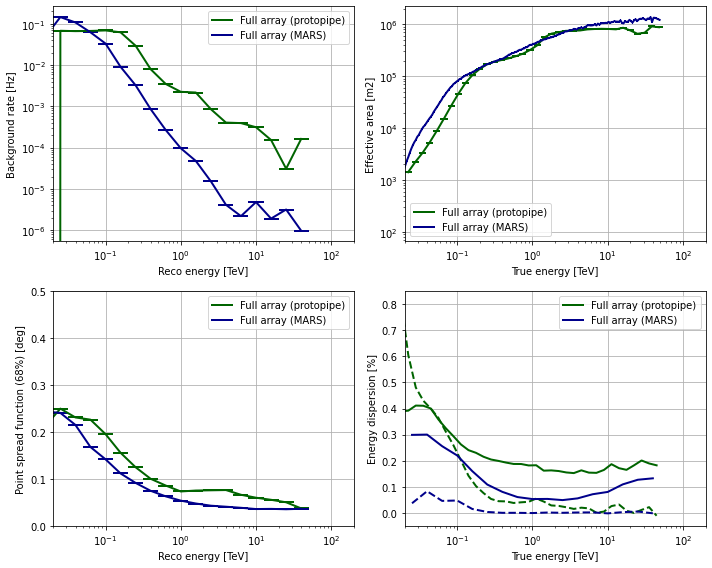

In [28]:
plt.figure(figsize=(10, 8))

ax_bkg = plt.subplot2grid((2, 2), (0, 0))
ax_area = plt.subplot2grid((2, 2), (0, 1))
ax_psf = plt.subplot2grid((2, 2), (1, 0))
ax_resol = plt.subplot2grid((2, 2), (1, 1))
axes = [ax_bkg, ax_area, ax_psf, ax_resol]

plot_irf(axes=axes, perf=perf[obs_time], label="Full array (protopipe)", energy_range=[0.01, 51.], **{'color': 'darkgreen', 'lw': 2})
plot_irf(axes=axes, perf=perf_mars_fullarray[obs_time], label="Full array (MARS)", energy_range=[0.01, 51.], **{'color': 'darkblue', 'lw': 2})

for ax in axes:
    ax.grid()
    ax.legend(loc='best')
    ax.set_xscale('log')
    ax.set_xlim([0.02, 200])

plt.tight_layout()
plt.savefig(f"./plots_DL3/IRFs_{site}_{array}_{obs_time}.png")

## Sensitivity
[back to top](#Table-of-contents)

/Users/michele/Applications/miniconda3/envs/protopipe-0.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


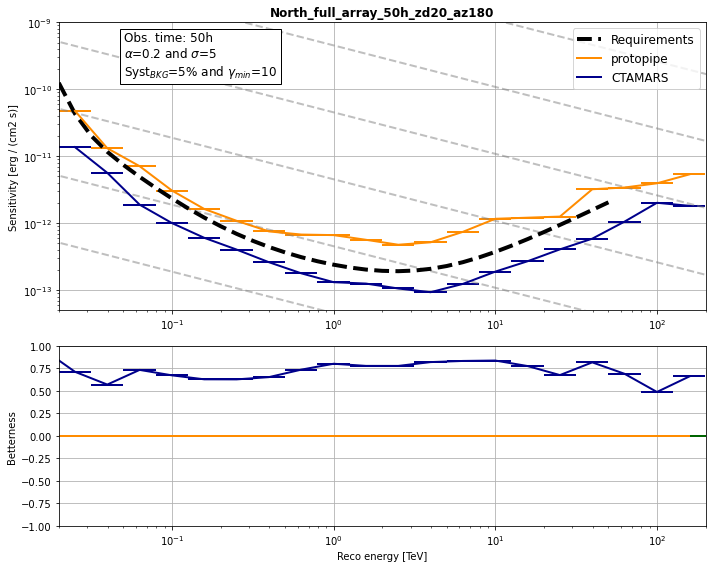

In [29]:
minEnergy = 2.e-2
maxEnergy = 2.e2

ax_sens, ax_res = plot_sensitivity_comparison(
    list_perf=[perf, perf_mars_fullarray],
    list_label=['protopipe', 'CTAMARS'],
    list_color=['darkorange', 'darkblue'],
    list_erange=[[minEnergy, maxEnergy], [minEnergy, maxEnergy]],
    perf_ref=perf,
    config=obs_time,
    title = f"{site}_{array}_{obs_time}_zd{zenith}_az{azimuth}",
    figsize=(10, 8)
)

ax_sens.plot(requirements['sens']['ENERGY'], 
             requirements['sens']['SENSITIVITY'], 
             color='black', 
             ls='--', 
             lw=4, 
             label='Requirements')

ax_sens.legend(loc='upper right', fontsize='large')

ax_res.set_xlim([minEnergy, maxEnergy])
ax_res.set_ylim([-1., 1.])

ax_sens.set_xlim([minEnergy, maxEnergy])
ax_sens.set_ylim([5.e-14, 1.e-9])

plt.tight_layout()
plt.savefig(f"./plots_DL3/sensitivity_{site}_{array}_{obs_time}.png")